In [1]:
# Célula 1: Imports Essenciais
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Modelos
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Métricas e Pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# Target & Feature Setup

**Target Variable:** `log_price`

**21 Feature Set:**
- Property attributes (bedrooms, bathrooms, sqft_living, etc.)
- Engineered features (house_age, price_per_sqft, etc.)
- Location features (zipcode_encoded, neighborhood demographics)
- Size comparisons (diff_sqft_living15, diff_sqft_lot15)

**Validation:** 5-fold K-Fold cross-validation

In [2]:
TARGET = 'log_price'

features = [
    'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront',
    'view', 'condition', 'grade', 'sqft_above', 'sqft_basement',
    'house_age', 'yrs_since_renovation', 'is_renovated',
    'price_per_sqft', 'living_lot_ratio', 'diff_sqft_living15',
    'diff_sqft_lot15', 'log_medn_income', 'log_hous_val',
    'per_bchlr', 'per_prfsnl', 'zipcode_encoded'
]
target = 'log_price'

In [ ]:
# Load the datasets with absolute paths
data = pd.read_csv('notebook_train_set.csv')
X = data.drop(["price", "log_price", "id", "date"], axis=1)
y = data[TARGET]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [6]:
# Validação robusta (K-Fold)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

## Linear Regression

Trained baseline Linear Regression model:
- 5-fold cross-validation
- Negative RMSE scoring
- Mean RMSE: `0.133`

*Simple linear baseline for performance comparison.*

In [5]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr_scores = cross_val_score(lr, X_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
print("Linear Regression - RMSE médio:", np.abs(lr_scores.mean()))

lr.fit(X_train, y_train)


Linear Regression - RMSE médio: 0.13293818409722494


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


## Regularized Models

Evaluated Ridge and Lasso regression:
- **Ridge (L2)**: Alpha=1.0 --> Mean RMSE: `0.133`
- **Lasso (L1)**: Alpha=0.001  --> Mean RMSE: `0.134`

*Regularization helps prevent overfitting and handle multicollinearity.*

In [6]:
from sklearn.linear_model import Ridge, Lasso

ridge = Ridge(alpha=1.0, random_state=42)
lasso = Lasso(alpha=0.001, random_state=42)

for model, name in zip([ridge, lasso], ['Ridge', 'Lasso']):
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
    print(f"{name} - RMSE médio:", np.abs(scores.mean()))


Ridge - RMSE médio: 0.1329374687573836


c:\Users\Rudá\desafio_data_science_madeinweb\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.639e+01, tolerance: 3.391e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Rudá\desafio_data_science_madeinweb\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.801e+01, tolerance: 3.461e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Rudá\desafio_data_science_madeinweb\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

Lasso - RMSE médio: 0.1337886425816993


c:\Users\Rudá\desafio_data_science_madeinweb\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.750e+01, tolerance: 3.447e-01
  model = cd_fast.enet_coordinate_descent(


## 🌳 Random Forest


- **300 estimators** with **max_depth=15**
- Parallel training (`n_jobs=-1`)
- Mean RMSE: `0.02`
*Captures non-linear relationships and feature interactions.*

In [7]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300, max_depth=15, random_state=42, n_jobs=-1
)
rf_scores = cross_val_score(rf, X_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
print("Random Forest - RMSE médio:", np.abs(rf_scores.mean()))

rf.fit(X_train, y_train)


Random Forest - RMSE médio: 0.02609002427948509


,n_estimators,300
,criterion,'squared_error'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## XGBoost Model

Configured with optimized parameters:
- **1000 estimators** with **learning_rate=0.05**
- **max_depth=6** for balanced complexity
- **subsample=0.8** & **colsample_bytree=0.8** for robustness
- Mean RMSE: `0.02`

*High-performance gradient boosting with regularization.*

In [11]:
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt

xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## Checking model performance

In [12]:
from sklearn.metrics import mean_squared_error
import numpy as np

# predições
y_pred = xgb_model.predict(X_valid)

# converte de log_price para price
y_true_real = np.expm1(y_valid)
y_pred_real = np.expm1(y_pred)



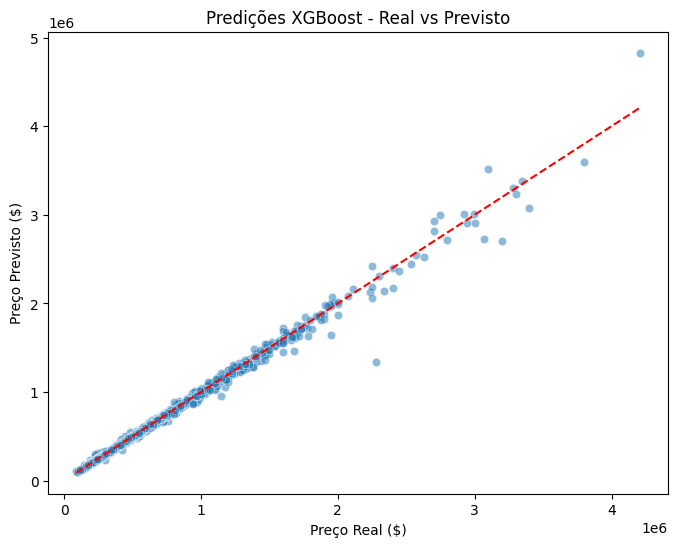

In [13]:

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_true_real, y=y_pred_real, alpha=0.5)
plt.plot([y_true_real.min(), y_true_real.max()],
         [y_true_real.min(), y_true_real.max()],
         color='red', linestyle='--')
plt.xlabel("Preço Real ($)")
plt.ylabel("Preço Previsto ($)")
plt.title("Predições XGBoost - Real vs Previsto")
plt.show()


## XGBoost Feature Importance

**Top Predictive Features:**
1. **zipcode_encoded** - Location-based pricing
2. **sqft_living** & **grade** - Property size and quality  
3. **price_per_sqft** - Value efficiency metric
4. **per_prfsnl** & **per_bchlr** - Neighborhood demographics

**Insights:** Location, size, and neighborhood characteristics drive predictions most significantly.

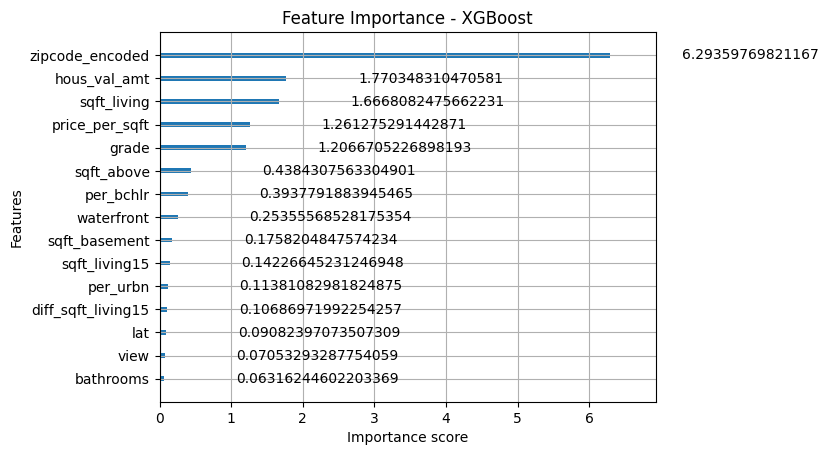

In [14]:
# Agora sim:
plot_importance(xgb_model, max_num_features=15, importance_type='gain', title='Feature Importance - XGBoost')
plt.show()

## Finding the Best Parameters for XGBoost

In [19]:
from sklearn.model_selection import GridSearchCV

# Smaller parameter grid for GridSearch
param_grid = {
    'n_estimators': [300, 500, 1000],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'learning_rate': [0.05, 0.1, ...], 'max_depth': [4, 6, ...], 'n_estimators': [300, 500, ...], 'subsample': [0.7, 0.8, ...]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


### 1. **Evaluate Optimized Model**

In [20]:
# Get the best model from GridSearchCV
best_xgb = grid_search.best_estimator_

test_predictions = best_xgb.predict(X_valid)
test_rmse = np.sqrt(mean_squared_error(y_valid, test_predictions))
print(f"Test RMSE: {test_rmse}")

Test RMSE: 0.02179553618021631


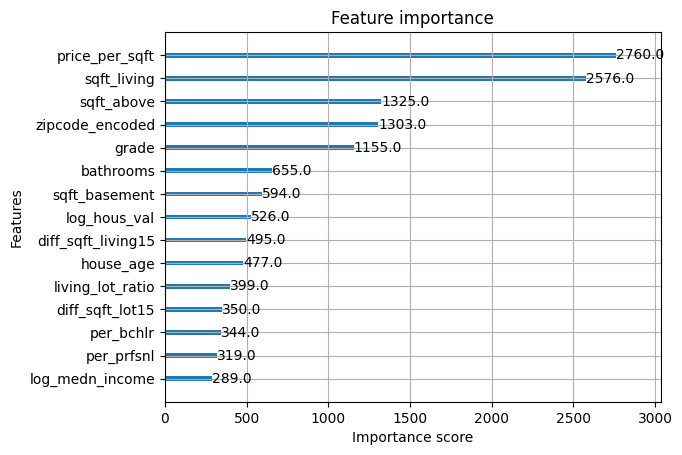

In [21]:
# Plot feature importance
plot_importance(best_xgb, max_num_features=15)
plt.show()

In [ ]:
TARGET = 'log_price'

features = [
    'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront',
    'view', 'condition', 'grade', 'sqft_above', 'sqft_basement',
    'house_age', 'yrs_since_renovation', 'is_renovated',
    'price_per_sqft', 'living_lot_ratio', 'diff_sqft_living15',
    'diff_sqft_lot15', 'log_medn_income', 'log_hous_val',
    'per_bchlr', 'per_prfsnl', 'zipcode_encoded'
]
target = 'log_price'